## Galaxy_viewer

Produces an image of a single galaxy or several

In [11]:
import numpy as np
import matplotlib
import pandas as pd
import gc
# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt

import lsst.daf.butler as dafButler     # gen3 butler
from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS

import lsst.sphgeom
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.geom import SpherePoint, Angle
afwDisplay.setDefaultBackend('matplotlib') 

butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
filter_id = 'r'

In [12]:
#a = pd.read_csv('input.txt', delim_whitespace = True)
#ra1 = a['RA']
#dec1 = a['DEC']
#print(len(ra1))

galaxies = pd.read_csv('truth_DP0_phosim_real.csv')
ra1 = galaxies['ra_1']
dec1 = galaxies['dec_1']

In [13]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [14]:
# Find the tract and patch for the coadd associated with a particular point
def find_tract_patch(ra, dec):
    my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    skymap = butler.get('skyMap')
    my_tract = skymap.findTract(my_spherePoint)
    my_patch = my_tract.findPatch(my_spherePoint)
    my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
    tract1 = str(my_tract)
    patch1_ok = str(my_patch_id)
    tract1_ok = tract1[13:17]
    tract = int(tract1_ok)
    patch = int(patch1_ok)
    dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}
    return dataId


In [15]:
#Shows the full image view
def full_image(ra, dec, dataId):
    datasetType = 'deepCoadd'
    coadd = butler.get(datasetType, **dataId)
    radec = SpherePoint(ra, dec, lsst.geom.degrees)
    xy = coadd.getWcs().skyToPixel(radec)
#    fig, ax = plt.subplots(xdim, ydim, figsize=(10, 10))
#    plt.sca(ax[0])

    fig = plt.figure(figsize=(20,20))
    display = afwDisplay.Display(frame=1, backend='matplotlib')
    display.scale("asinh", "zscale")
 #   display.mtv(image.getMaskedImage().getImage())
    
 #   coadd.image.writeFits('output.fits')
    display.mtv(coadd.image)
    display.dot('o', xy.getX(), xy.getY(), ctype='green', size = 20)
  #  display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)
 #   plt.show()
  #  display.mtv(image.getMaskedImage().getImage())
    return


In [16]:
def cutout_coadd(butler, ra, dec, dataid, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

  #  coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=dataid)

    return cutout_image

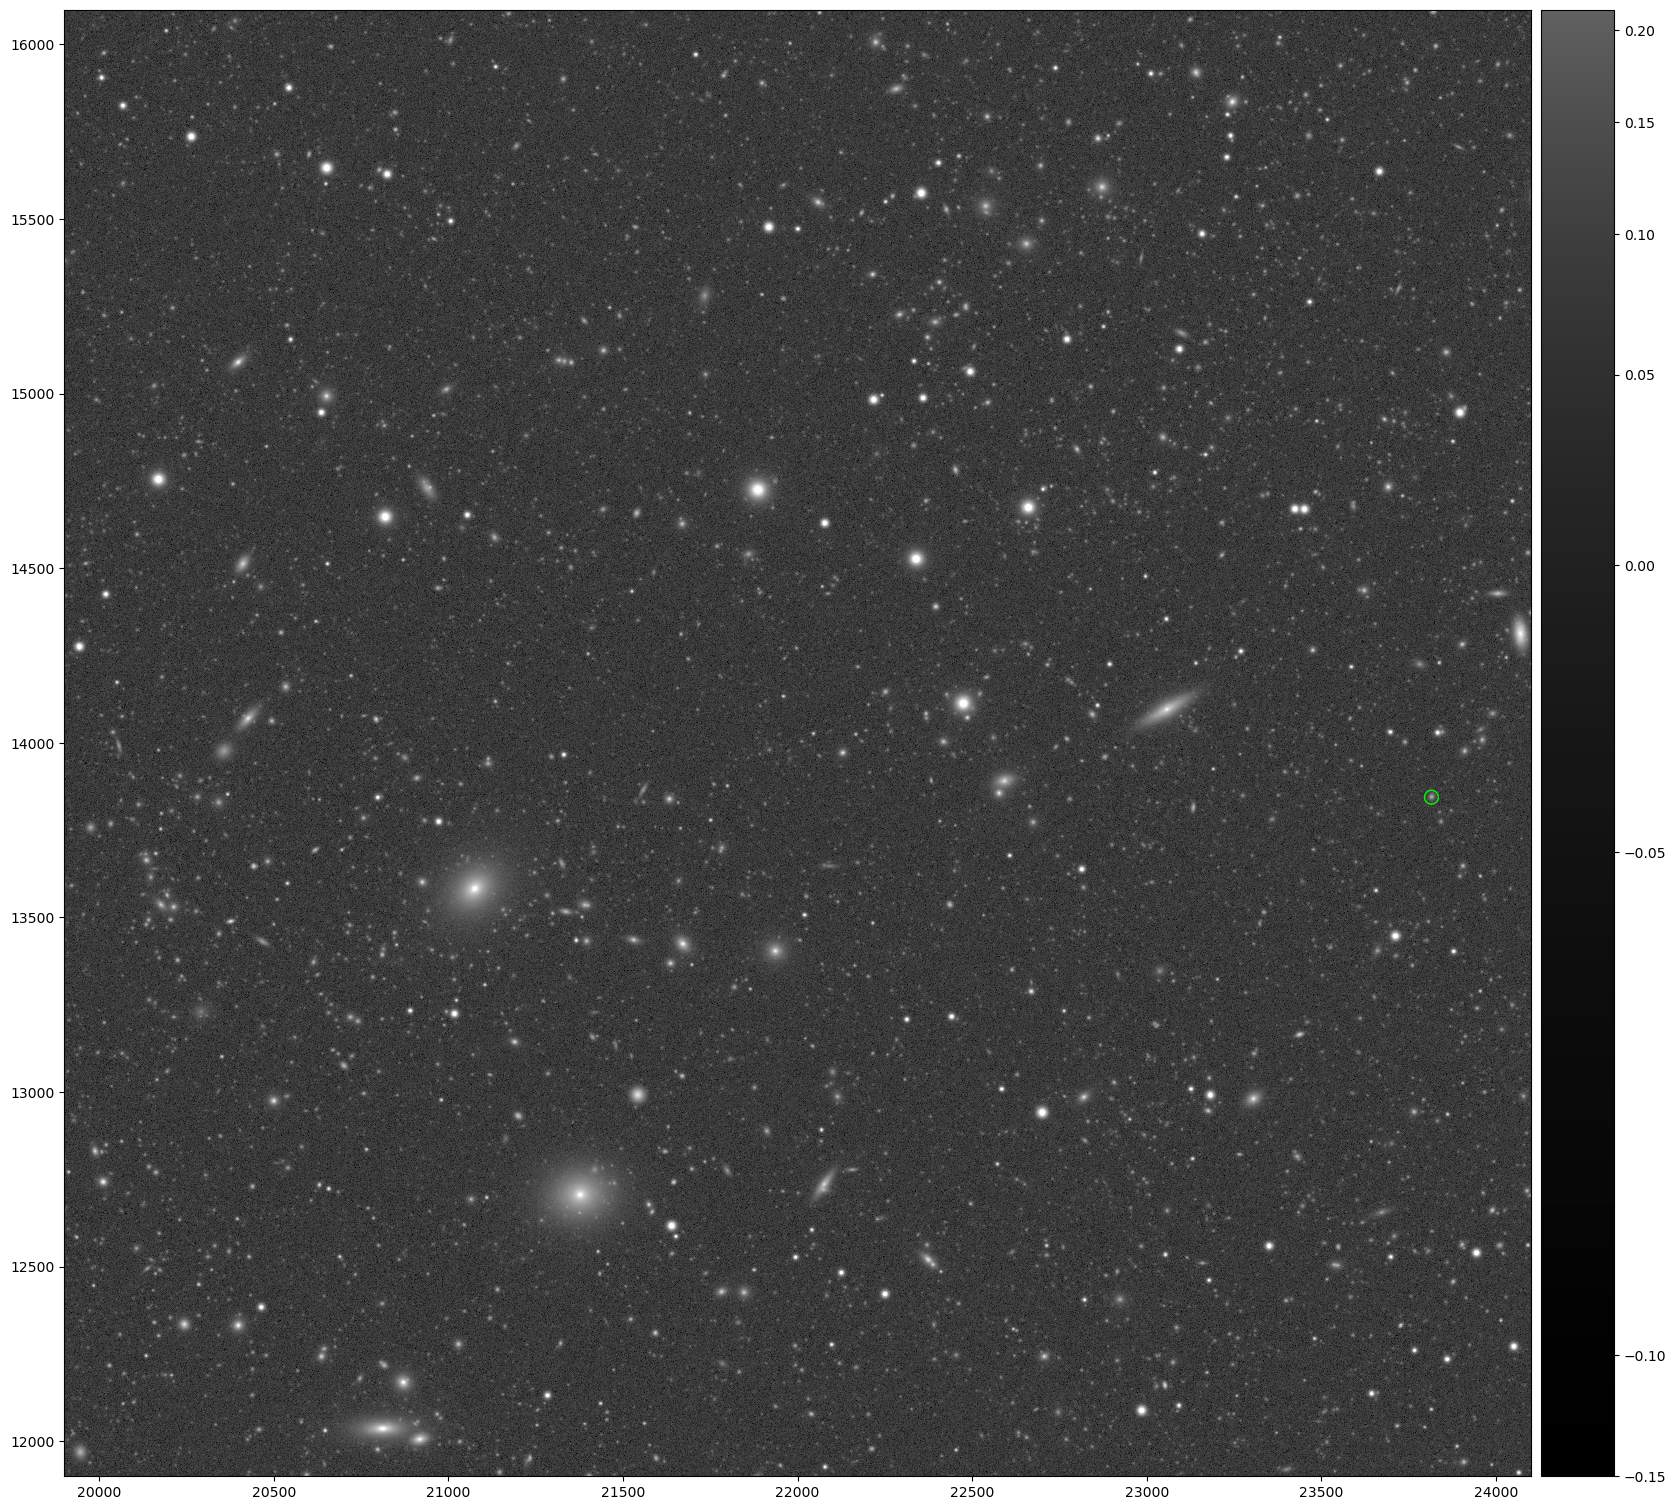

In [32]:
#ra = 57.6491576 edge on galaxy
#dec = -39.26560194
#ra = 59.6491576 
#dec = -37.26560194
#dataid = find_tract_patch(ra,dec)
#full_image(ra,dec,dataid)


i=(3)
#for i in range(1,2):
dataid = find_tract_patch(ra1[i],dec1[i])
full_image(ra1[i],dec1[i],dataid)
#    input()


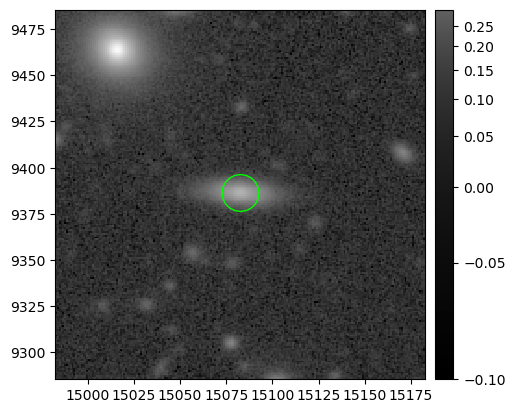

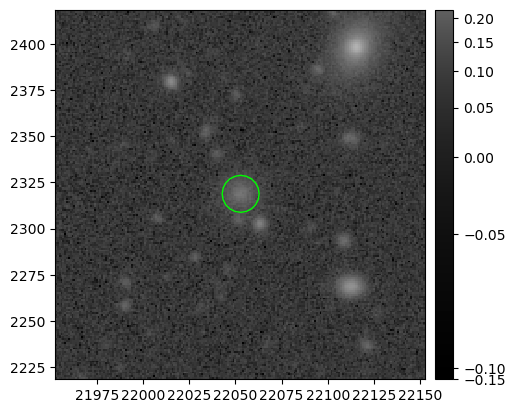

KeyboardInterrupt: 

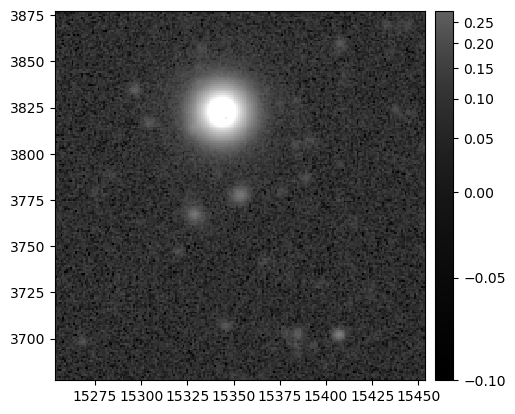

In [61]:
# this loop sets i as a range of the 20 host galaxies so that it prints 20 individual host galaxies

for i in range(20):

    ra = ra1[i]
    dec = dec1[i]
    
# setting the tract patch for the images 
    dataid = find_tract_patch(ra,dec)
    cutout_image = cutout_coadd(butler, ra, dec, dataid, band='i', datasetType='deepCoadd',
                            cutoutSideLength=200)
    fig, ax = plt.subplots()
    radec = SpherePoint(ra, dec, lsst.geom.degrees) #  combines the ra and dec to an object that can be read by skytoPixel to find xy coordinates
    xy = cutout_image.getWcs().skyToPixel(radec) # finds the pixel positions on an image that corresponses to a WCS (ra and dec) position on the sky
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')    # sets the scale to z-scale
    display.mtv(cutout_image.image) 
    display.dot('o', xy.getX(), xy.getY(), ctype='green', size = 10) #this establishes the specifics of the highlighting circle 
    plt.show()
    remove_figure(fig)